In [1]:
# Config Data Structure
import pandas as pd
from datetime import datetime as dt
from pymongo import MongoClient as mc
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import pprint as pp
import random as ran
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM
from tensorflow.keras.utils import to_categorical
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
weather_col = keti_db.weather_info
cluster_col = keti_db.cluster_info

In [46]:
# TimeSlot In
hh_db_datas = household_col.find_one({"uid": "아파트4-103-106"})
hh_db_datas

uid_in, timeslot = hh_db_datas['uid'], hh_db_datas['timeslot']

datelist = [
    dt.strptime(ts['time'], "%Y-%m-%d T%H:%M %z").date()
    for ts in timeslot
]
datelist = list(set(datelist))
datelist.sort()

ts_datas = {}
start_idx = 0
end_idx = 96
enl = 1

for date in datelist:
    ts_datas[date] = [ts['power'] *
                      enl for ts in timeslot[start_idx:end_idx]]
    start_idx = end_idx
    end_idx = end_idx + 96

ts_datas = pd.DataFrame(ts_datas).T
hh_datas = ts_datas.reset_index().copy()

hh_datas.rename(columns={"index": "date"}, inplace=True)
hh_datas['date'] = pd.to_datetime(hh_datas['date'])

hh_datas.set_index('date', inplace=True)

# Merging
merge_size = 4
merge_datas = pd.DataFrame()
for date in hh_datas.index:
    merge_ts = []
    new_ts_size = round(len(hh_datas.loc[date]) / merge_size)
    
    for idx in range(0,new_ts_size):
        merge_ts.append(
            round(hh_datas.loc[date][merge_size * idx:merge_size * (idx + 1)].sum(), 3) * 1000
        )
    if len(list(set(merge_ts))) >= 3:
        merge_datas[date] = merge_ts
    
def get_season_no(month):
    if month in [3,4,5]:
        return 1 # 봄
    elif month in [6,7,8]:
        return 2 # 여름
    elif month in [9,10,11]:
        return 3 # 가을
    elif month in [12,1,2]:
        return 4 # 겨울
    
# separate_datas_col = list(filter(lambda data: get_season_no(data.month) == 4, merge_datas.columns))
# print(separate_datas_col)
# merge_datas = merge_datas[separate_datas_col]
all_datas = merge_datas.copy()
merge_datas

,2018-05-01,2018-05-02,2018-05-03,2018-05-04,2018-05-05,2018-05-06,2018-05-07,2018-05-08,2018-05-09,2018-05-10,...,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30
0,365.0,315.0,345.0,377.0,369.0,375.0,388.0,374.0,313.0,374.0,...,131.0,115.0,127.0,460.0,124.0,90.0,110.0,86.0,155.0,92.0
1,340.0,347.0,302.0,335.0,333.0,416.0,286.0,450.0,253.0,352.0,...,127.0,132.0,132.0,244.0,104.0,112.0,104.0,103.0,105.0,92.0
2,353.0,312.0,319.0,330.0,302.0,359.0,233.0,359.0,216.0,346.0,...,146.0,112.0,110.0,247.0,122.0,117.0,100.0,107.0,115.0,223.0
3,386.0,305.0,308.0,310.0,326.0,317.0,248.0,362.0,239.0,435.0,...,115.0,118.0,141.0,329.0,126.0,94.0,112.0,113.0,105.0,155.0
4,329.0,316.0,311.0,302.0,315.0,314.0,233.0,343.0,240.0,381.0,...,120.0,132.0,126.0,276.0,96.0,93.0,94.0,100.0,94.0,110.0
5,337.0,309.0,358.0,311.0,370.0,307.0,510.0,339.0,234.0,359.0,...,127.0,187.0,107.0,248.0,118.0,153.0,97.0,98.0,96.0,100.0
6,1144.0,368.0,628.0,458.0,406.0,598.0,381.0,1052.0,262.0,432.0,...,126.0,120.0,141.0,248.0,119.0,143.0,119.0,117.0,112.0,105.0
7,715.0,1431.0,1154.0,1271.0,664.0,385.0,1448.0,1299.0,1320.0,1077.0,...,123.0,144.0,117.0,1439.0,94.0,121.0,121.0,88.0,117.0,100.0
8,284.0,773.0,423.0,518.0,715.0,377.0,767.0,403.0,888.0,785.0,...,143.0,131.0,124.0,413.0,97.0,121.0,164.0,97.0,75.0,104.0
9,455.0,385.0,435.0,596.0,863.0,861.0,447.0,559.0,502.0,606.0,...,210.0,132.0,126.0,342.0,118.0,113.0,90.0,118.0,103.0,95.0


In [47]:
# Set Test Datas
# 계절별 10% 랜덤하게
def get_season_no(month):
    if month in [3,4,5]:
        return 1 # 봄
    elif month in [6,7,8]:
        return 2 # 여름
    elif month in [9,10,11]:
        return 3 # 가을
    elif month in [12,1,2]:
        return 4 # 겨울
    
test_merge_datas = pd.DataFrame();

for i in range(1,5):
    filter_list = list(filter(lambda date: get_season_no(date.month) == i, merge_datas.columns))
    test_list_idx = list()
    while True:
        filter_data = filter_list[ran.randrange(0,len(filter_list))]
        if filter_data not in test_list_idx:
            test_list_idx.append(filter_data)
            
        if len(test_list_idx) >= (len(filter_list) * 15 / 100):
            break;
    test_merge_datas = pd.concat([test_merge_datas, merge_datas[test_list_idx]], axis=1)
    merge_datas.drop(test_list_idx, axis=1, inplace=True)

test_merge_datas

,2018-05-29,2019-04-10,2019-03-25,2019-03-19,2019-03-30,2019-03-12,2018-05-08,2019-04-29,2019-03-20,2019-03-02,...,2018-12-16,2018-12-25,2018-12-30,2019-02-19,2019-01-14,2018-12-17,2019-02-10,2019-02-01,2019-02-12,2019-02-13
0,267.0,118.0,158.0,134.0,121.0,205.0,374.0,155.0,103.0,165.0,...,393.0,407.0,459.0,108.0,396.0,320.0,156.0,802.0,164.0,155.0
1,221.0,217.0,159.0,139.0,210.0,217.0,450.0,105.0,104.0,214.0,...,327.0,328.0,331.0,159.0,354.0,397.0,155.0,472.0,136.0,167.0
2,179.0,129.0,169.0,144.0,148.0,240.0,359.0,115.0,177.0,175.0,...,315.0,312.0,404.0,136.0,352.0,342.0,164.0,417.0,155.0,132.0
3,160.0,132.0,202.0,163.0,121.0,224.0,362.0,105.0,169.0,137.0,...,336.0,328.0,324.0,137.0,358.0,323.0,126.0,234.0,153.0,134.0
4,169.0,97.0,157.0,170.0,106.0,233.0,343.0,94.0,170.0,157.0,...,294.0,314.0,357.0,200.0,365.0,316.0,168.0,258.0,141.0,163.0
5,211.0,120.0,170.0,168.0,102.0,240.0,339.0,96.0,119.0,142.0,...,292.0,344.0,421.0,176.0,321.0,302.0,155.0,254.0,143.0,152.0
6,259.0,82.0,165.0,153.0,109.0,226.0,1052.0,112.0,116.0,151.0,...,382.0,393.0,366.0,119.0,321.0,310.0,169.0,250.0,151.0,138.0
7,880.0,119.0,146.0,162.0,108.0,755.0,1299.0,117.0,163.0,128.0,...,409.0,543.0,366.0,145.0,472.0,985.0,140.0,264.0,141.0,145.0
8,539.0,95.0,166.0,157.0,96.0,250.0,403.0,75.0,158.0,146.0,...,1294.0,1569.0,1175.0,142.0,1993.0,1455.0,139.0,1423.0,153.0,141.0
9,389.0,110.0,134.0,154.0,106.0,227.0,559.0,103.0,179.0,153.0,...,1150.0,750.0,892.0,131.0,544.0,1066.0,161.0,556.0,157.0,159.0


In [48]:
y = reduce(lambda acc, cur: cur + acc ,merge_datas.values.tolist(), [])
value_size = len(y)
print(value_size)

7368


In [49]:
# Config Training Datas
wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

for wt in wt_db_datas:
    tmp = pd.DataFrame()
    tmp['date'] = [wt['date']]
    tmp['weather'] = [wt['weather']]
    tmp['avg_ta'] = round(float(wt['avgTa']))
    tmp['avg_rhm'] = round(float(wt['avgRhm']))
    
    wt_datas = pd.concat([wt_datas, tmp])

# 영하 온도 전처리
min_ta = min(wt_datas['avg_ta'])
wt_datas['avg_ta'] += (min_ta * -1 + 1)
min(wt_datas['avg_ta'])

1

In [50]:
# weather 정수 인코딩
weather_count = Counter(wt_datas['weather'])
weather_integer = dict()
rank = 1
for key, count in weather_count.most_common():
    weather_integer[key] = rank
    rank += 1
pp.pprint(weather_integer)
wt_datas['weather_no'] = [weather_integer[weather] for weather in wt_datas['weather']]
wt_datas

def get_season_no(month):
    if month in [3,4,5]:
        return 1 # 봄
    elif month in [6,7,8]:
        return 2 # 여름
    elif month in [9,10,11]:
        return 3 # 가을
    elif month in [12,1,2]:
        return 4 # 겨울
    
# Date, Season Utils
wt_datas['season_no'] = [get_season_no(weather.month) for weather in wt_datas['date']] 
wt_datas['day_no'] = [weather.weekday() + 1 for weather in wt_datas['date']] 

sample_weather_col = ['season_no','day_no','weather_no','avg_ta', 'avg_rhm']
sample_weather_col_2 = ['date','season_no','day_no','weather','weather_no','avg_ta', 'avg_rhm']
wt_datas[sample_weather_col_2]

{'눈': 5,
 '박무': 4,
 '비': 3,
 '소나기': 7,
 '안개': 10,
 '안개비': 11,
 '연무': 2,
 '진눈깨비': 12,
 '채운': 8,
 '특이사항 없음': 1,
 '햇무리': 6,
 '황사': 9}


,date,season_no,day_no,weather,weather_no,avg_ta,avg_rhm
0,2018-05-01,1,2,연무,2,31,73
0,2018-05-02,1,3,비,3,26,90
0,2018-05-03,1,4,비,3,22,62
0,2018-05-04,1,5,특이사항 없음,1,25,46
0,2018-05-05,1,6,특이사항 없음,1,29,47
...,...,...,...,...,...,...,...
0,2019-04-26,1,5,비,3,19,82
0,2019-04-27,1,6,햇무리,6,23,53
0,2019-04-28,1,7,비,3,24,49
0,2019-04-29,1,1,햇무리,6,24,53


In [51]:
# Config Sample Datas - Padding
# Data Preprocessing
def get_samples(datas):
    samples = list()
    for col in datas:
        timeslot = datas[col].values.tolist()
        weather = wt_datas[wt_datas['date'] == col][sample_weather_col].values.tolist()[0]
        for time in range(1,25):
            samples.append(weather + timeslot[:time])

    print("Samples Before Padding Process")
    print(np.array(samples))
    print("\nTranining Sample Size : {}".format(len(samples)))
    
    return samples

def get_padding_samples(samples):    
    # Padding
    pad_samples = list()
    SAMPLE_MAX_LEN = max([len(s) for s in samples])
    print("Tranining Sample MAX_LEN : {}".format(SAMPLE_MAX_LEN))
    for sample in samples:
        err = SAMPLE_MAX_LEN - len(sample)
        if err == 0:
            pad_samples.append(sample)
        else:
            pad_data = [0 for i in range(0, err)]
            pad_samples.append(pad_data + sample)
    print("\nFinal Samples")
    print(np.array(pad_samples))
    
    return pad_samples
    
test_samples = get_samples(test_merge_datas)
test_samples = get_padding_samples(test_samples)

training_samples = get_samples(merge_datas)
training_samples = get_padding_samples(training_samples)

Samples Before Padding Process
[list([1, 2, 2, 32, 69, 267.0]) list([1, 2, 2, 32, 69, 267.0, 221.0])
 list([1, 2, 2, 32, 69, 267.0, 221.0, 179.0]) ...
 list([4, 3, 1, 9, 27, 155.0, 167.0, 132.0, 134.0, 163.0, 152.0, 138.0, 145.0, 141.0, 159.0, 131.0, 182.0, 156.0, 141.0, 139.0, 147.0, 163.0, 149.0, 147.0, 148.0, 144.0, 150.0])
 list([4, 3, 1, 9, 27, 155.0, 167.0, 132.0, 134.0, 163.0, 152.0, 138.0, 145.0, 141.0, 159.0, 131.0, 182.0, 156.0, 141.0, 139.0, 147.0, 163.0, 149.0, 147.0, 148.0, 144.0, 150.0, 135.0])
 list([4, 3, 1, 9, 27, 155.0, 167.0, 132.0, 134.0, 163.0, 152.0, 138.0, 145.0, 141.0, 159.0, 131.0, 182.0, 156.0, 141.0, 139.0, 147.0, 163.0, 149.0, 147.0, 148.0, 144.0, 150.0, 135.0, 186.0])]

Tranining Sample Size : 1344
Tranining Sample MAX_LEN : 29

Final Samples
[[  0.   0.   0. ...  32.  69. 267.]
 [  0.   0.   0. ...  69. 267. 221.]
 [  0.   0.   0. ... 267. 221. 179.]
 ...
 [  0.   0.   4. ... 148. 144. 150.]
 [  0.   4.   3. ... 144. 150. 135.]
 [  4.   3.   1. ... 150. 13

<ipython-input-51-f7267c0eac4d>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(samples))



[[  0.   0.   0. ...  31.  73. 365.]
 [  0.   0.   0. ...  73. 365. 340.]
 [  0.   0.   0. ... 365. 340. 353.]
 ...
 [  0.   0.   1. ... 325. 164. 167.]
 [  0.   1.   2. ... 164. 167. 145.]
 [  1.   2.   6. ... 167. 145. 141.]]


In [52]:
# Set Tranining Data (non-cluster-model)
training_samples = np.array(training_samples)

train_X = training_samples[:,:-1]
train_y = training_samples[:,-1]

# Set Test Data
test_samples = np.array(test_samples)
test_X = test_samples[:,:-1]
test_y = test_samples[:,-1]

print("Input Data For Training")
print(np.array(train_X))
print()
print("Output Data For Training")
print(np.array(train_y))

print("Input Data For Test")
print(np.array(test_X))
print()
print("Output Data For Test")
print(np.array(test_y))

Input Data For Training
[[  0.   0.   0. ...   2.  31.  73.]
 [  0.   0.   0. ...  31.  73. 365.]
 [  0.   0.   0. ...  73. 365. 340.]
 ...
 [  0.   0.   1. ... 786. 325. 164.]
 [  0.   1.   2. ... 325. 164. 167.]
 [  1.   2.   6. ... 164. 167. 145.]]

Output Data For Training
[365. 340. 353. ... 167. 145. 141.]
Input Data For Test
[[  0.   0.   0. ...   2.  32.  69.]
 [  0.   0.   0. ...  32.  69. 267.]
 [  0.   0.   0. ...  69. 267. 221.]
 ...
 [  0.   0.   4. ... 147. 148. 144.]
 [  0.   4.   3. ... 148. 144. 150.]
 [  4.   3.   1. ... 144. 150. 135.]]

Output Data For Test
[267. 221. 179. ... 150. 135. 186.]


In [53]:
one_hot_y = to_categorical(train_y,num_classes=value_size)
one_hot_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [55]:
import time

cluster_merge_datas = merge_datas.copy()

infos = list()
SEASONSARR = ["봄", "여름", "가을", "겨울"]
for season in SEASONSARR:
    cluster_info = cluster_col.find_one({"$and" : [{
      "uid": "아파트4-103-106"  
    }, {
       "season": season
    }]
                                        }) 
    infos.extend(cluster_info['info'])
    
filter_idx_list = [dt.strptime(info['date'], "%Y-%m-%d") for info in infos]
filter_idx_list
cluster_all_datas = all_datas[filter_idx_list].copy()
for col in merge_datas.columns:
    if col not in filter_idx_list:
        cluster_merge_datas.drop([col], axis=1, inplace=True)

cluster_merge_datas

,2018-05-01,2018-05-02,2018-05-04,2018-05-05,2018-05-06,2018-05-07,2018-05-09,2018-05-10,2018-05-11,2018-05-12,...,2019-04-16,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-24,2019-04-25,2019-04-27,2019-04-28
0,365.0,315.0,377.0,369.0,375.0,388.0,313.0,374.0,338.0,426.0,...,90.0,136.0,143.0,144.0,131.0,115.0,460.0,124.0,110.0,86.0
1,340.0,347.0,335.0,333.0,416.0,286.0,253.0,352.0,333.0,298.0,...,127.0,119.0,124.0,122.0,127.0,132.0,244.0,104.0,104.0,103.0
2,353.0,312.0,330.0,302.0,359.0,233.0,216.0,346.0,353.0,340.0,...,82.0,144.0,125.0,131.0,146.0,112.0,247.0,122.0,100.0,107.0
3,386.0,305.0,310.0,326.0,317.0,248.0,239.0,435.0,318.0,398.0,...,115.0,123.0,129.0,132.0,115.0,118.0,329.0,126.0,112.0,113.0
4,329.0,316.0,302.0,315.0,314.0,233.0,240.0,381.0,339.0,370.0,...,109.0,131.0,132.0,120.0,120.0,132.0,276.0,96.0,94.0,100.0
5,337.0,309.0,311.0,370.0,307.0,510.0,234.0,359.0,305.0,364.0,...,104.0,133.0,123.0,110.0,127.0,187.0,248.0,118.0,97.0,98.0
6,1144.0,368.0,458.0,406.0,598.0,381.0,262.0,432.0,1028.0,441.0,...,96.0,123.0,131.0,140.0,126.0,120.0,248.0,119.0,119.0,117.0
7,715.0,1431.0,1271.0,664.0,385.0,1448.0,1320.0,1077.0,1490.0,1098.0,...,221.0,108.0,137.0,121.0,123.0,144.0,1439.0,94.0,121.0,88.0
8,284.0,773.0,518.0,715.0,377.0,767.0,888.0,785.0,511.0,684.0,...,167.0,143.0,116.0,111.0,143.0,131.0,413.0,97.0,164.0,97.0
9,455.0,385.0,596.0,863.0,861.0,447.0,502.0,606.0,364.0,846.0,...,95.0,241.0,241.0,249.0,210.0,132.0,342.0,118.0,90.0,118.0


In [57]:
label_dict = dict()

for info in infos:
    label_dict[dt.strptime(info['date'], "%Y-%m-%d")] = info['label']

label_dict

{datetime.datetime(2018, 5, 1, 0, 0): 1,
 datetime.datetime(2018, 5, 2, 0, 0): 5,
 datetime.datetime(2018, 5, 4, 0, 0): 5,
 datetime.datetime(2018, 5, 5, 0, 0): 1,
 datetime.datetime(2018, 5, 6, 0, 0): 1,
 datetime.datetime(2018, 5, 7, 0, 0): 5,
 datetime.datetime(2018, 5, 8, 0, 0): 5,
 datetime.datetime(2018, 5, 9, 0, 0): 5,
 datetime.datetime(2018, 5, 10, 0, 0): 5,
 datetime.datetime(2018, 5, 11, 0, 0): 5,
 datetime.datetime(2018, 5, 12, 0, 0): 1,
 datetime.datetime(2018, 5, 13, 0, 0): 1,
 datetime.datetime(2018, 5, 14, 0, 0): 5,
 datetime.datetime(2018, 5, 15, 0, 0): 5,
 datetime.datetime(2018, 5, 16, 0, 0): 1,
 datetime.datetime(2018, 5, 18, 0, 0): 1,
 datetime.datetime(2018, 5, 19, 0, 0): 5,
 datetime.datetime(2018, 5, 21, 0, 0): 5,
 datetime.datetime(2018, 5, 22, 0, 0): 4,
 datetime.datetime(2018, 5, 23, 0, 0): 4,
 datetime.datetime(2018, 5, 24, 0, 0): 5,
 datetime.datetime(2018, 5, 25, 0, 0): 5,
 datetime.datetime(2018, 5, 26, 0, 0): 5,
 datetime.datetime(2018, 5, 27, 0, 0): 5,


In [86]:
# Config Cluster Pattern
label_lists = list()
cluster_dict = dict()
for season_no in range(1,5):
    filter_season_info = list(filter(lambda info: 
                                     get_season_no(dt.strptime(info['date'],
                                                "%Y-%m-%d").month) == season_no, infos))
    label_list = [info['label'] for info in filter_season_info]
    label_list = list(set(label_list))
    label_lists.append(label_list)
    
for idx,label_list in enumerate(label_lists):
    tmp_dict = dict()
    for label in label_list:
        dates = [
            dt.strptime(filter_info['date'], "%Y-%m-%d") for filter_info in
            list(filter(lambda info: info['label'] == label, infos))
        ]
        tmp_dict[label] = [round(cd) for cd in cluster_all_datas[dates].T.mean().values]
    cluster_dict[idx + 1] = tmp_dict
    
pp.pprint(cluster_dict)

{1: {0: [437,
         324,
         303,
         290,
         286,
         270,
         387,
         1082,
         1196,
         557,
         480,
         985,
         956,
         559,
         553,
         496,
         563,
         617,
         1125,
         990,
         684,
         472,
         470,
         473],
     1: [336,
         315,
         297,
         293,
         302,
         311,
         383,
         727,
         735,
         859,
         618,
         470,
         380,
         454,
         461,
         386,
         389,
         557,
         694,
         841,
         784,
         534,
         409,
         352],
     2: [223,
         215,
         210,
         209,
         207,
         210,
         241,
         384,
         714,
         353,
         254,
         245,
         227,
         209,
         213,
         228,
         204,
         292,
         337,
         315,
         496,
         404,
         333,
 

In [92]:
def get_samples_2(datas):
    samples = list()
    for col in datas:
        timeslot = datas[col].values.tolist()
        weather = wt_datas[wt_datas['date'] == col][sample_weather_col].values.tolist()[0]
        label = label_dict[col]
        cluster_pattern = cluster_dict[get_season_no(col.month)][label]
        for time in range(0,24):
            samples.append(weather + timeslot[:time] + [cluster_pattern[time]])

#     print("Samples Before Padding Process")
#     print(np.array(samples))
#     print("\nTranining Sample Size : {}".format(len(samples)))
    
    return samples


cluster_training_samples = get_samples_2(cluster_merge_datas)
cluster_training_samples = get_padding_samples(cluster_training_samples)
cluster_training_samples

Tranining Sample MAX_LEN : 29

Final Samples
[[  0.   0.   0. ...  31.  73. 336.]
 [  0.   0.   0. ...  73. 365. 315.]
 [  0.   0.   0. ... 365. 340. 297.]
 ...
 [  0.   0.   1. ... 112.  97. 404.]
 [  0.   1.   7. ...  97.  92. 333.]
 [  1.   7.   3. ...  92. 119. 249.]]


[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  2,
  31,
  73,
  336],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  2,
  31,
  73,
  365.0,
  315],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  2,
  31,
  73,
  365.0,
  340.0,
  297],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  2,
  31,
  73,
  365.0,
  340.0,
  353.0,
  293],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  2,
  31,
  73,
  365.0,
  340.0,
  353.0,
  386.0,
  302],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  2,
  31,
  73,
  365.0,
  340.0,
  353.0,
  386.0,
  329.0,
  311],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [95]:
cluster_training_samples = np.array(training_samples)

cluster_train_X = training_samples[:,:-1]
cluster_train_y = training_samples[:,-1]

cluster_train_X
cluster_train_y

array([365., 340., 353., ..., 167., 145., 141.])

In [97]:
cluster_one_hot_y = to_categorical(cluster_train_y)
cluster_one_hot_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [99]:
non_cluster_model = Sequential(name="rnn-model-1-101-1602")
non_cluster_model.add(Embedding(value_size, 10, input_length=28))
non_cluster_model.add(LSTM(128))
non_cluster_model.add(Dense(value_size, activation='softmax'))
non_cluster_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

non_cluster_model.summary()

Model: "rnn-model-1-101-1602"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 10)            73680     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               71168     
_________________________________________________________________
dense (Dense)                (None, 7368)              950472    
Total params: 1,095,320
Trainable params: 1,095,320
Non-trainable params: 0
_________________________________________________________________


In [105]:
cluster_model = Sequential(name="rnn-model-1-101-1602")
cluster_model.add(Embedding(len(cluster_one_hot_y), 10, input_length=28))
cluster_model.add(LSTM(128))
cluster_model.add(Dense(2964, activation='softmax'))
cluster_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cluster_model.summary()

Model: "rnn-model-1-101-1602"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 28, 10)            73680     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               71168     
_________________________________________________________________
dense_4 (Dense)              (None, 2964)              382356    
Total params: 527,204
Trainable params: 527,204
Non-trainable params: 0
_________________________________________________________________


In [106]:
cluster_model.fit(cluster_train_X, cluster_one_hot_y, epochs=300, verbose=2)

Epoch 1/300
231/231 - 4s - loss: 7.0782 - accuracy: 0.0042
Epoch 2/300
231/231 - 2s - loss: 6.5953 - accuracy: 0.0062
Epoch 3/300
231/231 - 2s - loss: 6.4122 - accuracy: 0.0057
Epoch 4/300
231/231 - 2s - loss: 6.2523 - accuracy: 0.0077
Epoch 5/300
231/231 - 3s - loss: 6.1152 - accuracy: 0.0109
Epoch 6/300
231/231 - 3s - loss: 5.9730 - accuracy: 0.0111
Epoch 7/300
231/231 - 2s - loss: 5.8289 - accuracy: 0.0143
Epoch 8/300
231/231 - 3s - loss: 5.6912 - accuracy: 0.0174
Epoch 9/300
231/231 - 3s - loss: 5.5588 - accuracy: 0.0214
Epoch 10/300
231/231 - 3s - loss: 5.4338 - accuracy: 0.0248
Epoch 11/300
231/231 - 3s - loss: 5.3124 - accuracy: 0.0309
Epoch 12/300
231/231 - 3s - loss: 5.1992 - accuracy: 0.0328
Epoch 13/300
231/231 - 3s - loss: 5.0820 - accuracy: 0.0368
Epoch 14/300
231/231 - 3s - loss: 4.9675 - accuracy: 0.0483
Epoch 15/300
231/231 - 3s - loss: 4.8527 - accuracy: 0.0589
Epoch 16/300
231/231 - 3s - loss: 4.7456 - accuracy: 0.0698
Epoch 17/300
231/231 - 3s - loss: 4.6364 - accura

231/231 - 3s - loss: 0.4208 - accuracy: 0.9320
Epoch 138/300
231/231 - 3s - loss: 0.4309 - accuracy: 0.9270
Epoch 139/300
231/231 - 3s - loss: 0.4327 - accuracy: 0.9283
Epoch 140/300
231/231 - 3s - loss: 0.4065 - accuracy: 0.9355
Epoch 141/300
231/231 - 3s - loss: 0.4228 - accuracy: 0.9268
Epoch 142/300
231/231 - 3s - loss: 0.6318 - accuracy: 0.8711
Epoch 143/300
231/231 - 3s - loss: 0.5435 - accuracy: 0.9026
Epoch 144/300
231/231 - 3s - loss: 0.4032 - accuracy: 0.9347
Epoch 145/300
231/231 - 3s - loss: 0.3783 - accuracy: 0.9400
Epoch 146/300
231/231 - 3s - loss: 0.3668 - accuracy: 0.9425
Epoch 147/300
231/231 - 3s - loss: 0.3329 - accuracy: 0.9501
Epoch 148/300
231/231 - 3s - loss: 0.3222 - accuracy: 0.9507
Epoch 149/300
231/231 - 3s - loss: 0.3162 - accuracy: 0.9524
Epoch 150/300
231/231 - 3s - loss: 0.3268 - accuracy: 0.9495
Epoch 151/300
231/231 - 3s - loss: 0.3055 - accuracy: 0.9545
Epoch 152/300
231/231 - 3s - loss: 0.3369 - accuracy: 0.9469
Epoch 153/300
231/231 - 3s - loss: 0.3

Epoch 272/300
231/231 - 3s - loss: 0.0394 - accuracy: 0.9993
Epoch 273/300
231/231 - 3s - loss: 0.0365 - accuracy: 0.9995
Epoch 274/300
231/231 - 3s - loss: 0.0350 - accuracy: 0.9993
Epoch 275/300
231/231 - 3s - loss: 0.0361 - accuracy: 0.9995
Epoch 276/300
231/231 - 3s - loss: 0.1679 - accuracy: 0.9681
Epoch 277/300
231/231 - 3s - loss: 0.1912 - accuracy: 0.9632
Epoch 278/300
231/231 - 3s - loss: 0.1162 - accuracy: 0.9833
Epoch 279/300
231/231 - 3s - loss: 0.1704 - accuracy: 0.9689
Epoch 280/300
231/231 - 3s - loss: 0.1240 - accuracy: 0.9809
Epoch 281/300
231/231 - 3s - loss: 0.0679 - accuracy: 0.9957
Epoch 282/300
231/231 - 3s - loss: 0.0425 - accuracy: 0.9988
Epoch 283/300
231/231 - 3s - loss: 0.0507 - accuracy: 0.9978
Epoch 284/300
231/231 - 3s - loss: 0.0516 - accuracy: 0.9971
Epoch 285/300
231/231 - 3s - loss: 0.0382 - accuracy: 0.9995
Epoch 286/300
231/231 - 3s - loss: 0.0516 - accuracy: 0.9974
Epoch 287/300
231/231 - 3s - loss: 0.0539 - accuracy: 0.9970
Epoch 288/300
231/231 - 

In [107]:
non_cluster_model.fit(train_X, one_hot_y, epochs=300, verbose=2)

Epoch 1/300
231/231 - 6s - loss: 7.3461 - accuracy: 0.0049
Epoch 2/300
231/231 - 4s - loss: 6.6416 - accuracy: 0.0056
Epoch 3/300
231/231 - 5s - loss: 6.5094 - accuracy: 0.0058
Epoch 4/300
231/231 - 4s - loss: 6.3661 - accuracy: 0.0067
Epoch 5/300
231/231 - 4s - loss: 6.2271 - accuracy: 0.0083
Epoch 6/300
231/231 - 4s - loss: 6.1073 - accuracy: 0.0095
Epoch 7/300
231/231 - 4s - loss: 5.9789 - accuracy: 0.0121
Epoch 8/300
231/231 - 4s - loss: 5.8495 - accuracy: 0.0138
Epoch 9/300
231/231 - 4s - loss: 5.7271 - accuracy: 0.0152
Epoch 10/300
231/231 - 4s - loss: 5.6111 - accuracy: 0.0197
Epoch 11/300
231/231 - 4s - loss: 5.5004 - accuracy: 0.0206
Epoch 12/300
231/231 - 4s - loss: 5.3883 - accuracy: 0.0262
Epoch 13/300
231/231 - 4s - loss: 5.2871 - accuracy: 0.0284
Epoch 14/300
231/231 - 4s - loss: 5.1826 - accuracy: 0.0324
Epoch 15/300
231/231 - 4s - loss: 5.0838 - accuracy: 0.0409
Epoch 16/300
231/231 - 4s - loss: 4.9879 - accuracy: 0.0476
Epoch 17/300
231/231 - 4s - loss: 4.8906 - accura

231/231 - 4s - loss: 0.4798 - accuracy: 0.9144
Epoch 138/300
231/231 - 4s - loss: 0.4714 - accuracy: 0.9186
Epoch 139/300
231/231 - 4s - loss: 0.4659 - accuracy: 0.9176
Epoch 140/300
231/231 - 4s - loss: 0.4697 - accuracy: 0.9159
Epoch 141/300
231/231 - 4s - loss: 0.4679 - accuracy: 0.9188
Epoch 142/300
231/231 - 4s - loss: 0.5258 - accuracy: 0.9072
Epoch 143/300
231/231 - 4s - loss: 0.5089 - accuracy: 0.9077
Epoch 144/300
231/231 - 4s - loss: 0.4743 - accuracy: 0.9205
Epoch 145/300
231/231 - 4s - loss: 0.4554 - accuracy: 0.9199
Epoch 146/300
231/231 - 4s - loss: 0.4579 - accuracy: 0.9179
Epoch 147/300
231/231 - 4s - loss: 0.4207 - accuracy: 0.9258
Epoch 148/300
231/231 - 5s - loss: 0.4001 - accuracy: 0.9315
Epoch 149/300
231/231 - 4s - loss: 0.3943 - accuracy: 0.9330
Epoch 150/300
231/231 - 4s - loss: 0.3919 - accuracy: 0.9347
Epoch 151/300
231/231 - 4s - loss: 0.4136 - accuracy: 0.9281
Epoch 152/300
231/231 - 4s - loss: 0.4960 - accuracy: 0.9131
Epoch 153/300
231/231 - 4s - loss: 0.4

Epoch 272/300
231/231 - 4s - loss: 0.0873 - accuracy: 0.9938
Epoch 273/300
231/231 - 4s - loss: 0.0787 - accuracy: 0.9946
Epoch 274/300
231/231 - 4s - loss: 0.0687 - accuracy: 0.9963
Epoch 275/300
231/231 - 4s - loss: 0.0639 - accuracy: 0.9970
Epoch 276/300
231/231 - 4s - loss: 0.0606 - accuracy: 0.9969
Epoch 277/300
231/231 - 4s - loss: 0.0609 - accuracy: 0.9959
Epoch 278/300
231/231 - 4s - loss: 0.0571 - accuracy: 0.9971
Epoch 279/300
231/231 - 4s - loss: 0.0611 - accuracy: 0.9950
Epoch 280/300
231/231 - 4s - loss: 0.0627 - accuracy: 0.9950
Epoch 281/300
231/231 - 4s - loss: 0.0892 - accuracy: 0.9894
Epoch 282/300
231/231 - 4s - loss: 0.1593 - accuracy: 0.9735
Epoch 283/300
231/231 - 4s - loss: 0.2697 - accuracy: 0.9453
Epoch 284/300
231/231 - 4s - loss: 0.1767 - accuracy: 0.9705
Epoch 285/300
231/231 - 4s - loss: 0.1148 - accuracy: 0.9871
Epoch 286/300
231/231 - 4s - loss: 0.0885 - accuracy: 0.9923
Epoch 287/300
231/231 - 5s - loss: 0.0699 - accuracy: 0.9950
Epoch 288/300
231/231 - 

real_pattern: [267. 221. 179. 160. 169. 211. 259. 880. 539. 389. 649. 346. 207. 172.
 165. 219. 947. 213. 182. 222. 765. 447. 351. 284.]
predict_pattern: [267.0, 381.0, 337.0, 359.0, 316.0, 511.0, 233.0, 1279.0, 478.0, 241.0, 318.0, 187.0, 252.0, 240.0, 888.0, 458.0, 498.0, 261.0, 458.0, 355.0, 508.0, 508.0, 458.0, 1238.0]
real_pattern: [ 118.  217.  129.  132.   97.  120.   82.  119.   95.  110.   97.  104.
  106.   89.  336. 1218. 1622.  412.  551.   89.  128.   89.  129.   80.]
predict_pattern: [118.0, 452.0, 372.0, 239.0, 715.0, 369.0, 417.0, 380.0, 313.0, 314.0, 174.0, 360.0, 380.0, 359.0, 305.0, 201.0, 760.0, 459.0, 321.0, 352.0, 395.0, 200.0, 185.0, 511.0]
real_pattern: [158. 159. 169. 202. 157. 170. 165. 146. 166. 134. 161. 169. 154. 170.
 155. 466. 210. 142. 160. 479. 414. 314. 315. 297.]
predict_pattern: [158.0, 286.0, 385.0, 369.0, 383.0, 216.0, 313.0, 314.0, 319.0, 314.0, 385.0, 385.0, 1448.0, 498.0, 319.0, 385.0, 550.0, 760.0, 426.0, 338.0, 345.0, 211.0, 517.0, 1028.0]
rea

predict_pattern: [211.0, 359.0, 454.0, 380.0, 299.0, 888.0, 380.0, 254.0, 310.0, 501.0, 510.0, 305.0, 767.0, 282.0, 435.0, 378.0, 435.0, 298.0, 888.0, 172.0, 401.0, 176.0, 481.0, 1344.0]
real_pattern: [ 289.  175.  169.  171.  145.  193.  251. 1164.  524.  420.  235.  272.
  207.  197.  196.  301.  299.  297.  368.  283.  733.  554.  223.  198.]
predict_pattern: [289.0, 375.0, 511.0, 305.0, 1320.0, 174.0, 1348.0, 298.0, 976.0, 318.0, 517.0, 435.0, 374.0, 374.0, 478.0, 185.0, 367.0, 185.0, 355.0, 160.0, 503.0, 389.0, 481.0, 340.0]
real_pattern: [ 242.  185.  153.  184.  213.  158.  345. 1359.  967.  197.  168.  170.
  408.  220.  189.  208.  295.  218.  237.  957.  530.  570.  332.  263.]
predict_pattern: [242.0, 939.0, 1039.0, 234.0, 234.0, 234.0, 517.0, 298.0, 208.0, 285.0, 517.0, 286.0, 190.0, 366.0, 395.0, 454.0, 198.0, 248.0, 191.0, 628.0, 655.0, 340.0, 1344.0, 305.0]
real_pattern: [237. 196. 166. 143. 173. 199. 178. 340. 229. 209. 164. 146. 166. 184.
 169. 232. 237. 170. 705. 395.

predict_pattern: [459.0, 1495.0, 1348.0, 617.0, 233.0, 410.0, 507.0, 247.0, 316.0, 278.0, 192.0, 277.0, 355.0, 355.0, 318.0, 150.0, 243.0, 1773.0, 436.0, 488.0, 1746.0, 429.0, 213.0, 1328.0]
real_pattern: [108. 159. 136. 137. 200. 176. 119. 145. 142. 131. 138. 152. 122. 148.
 141. 139. 141. 155. 133. 149. 118. 152. 141. 121.]
predict_pattern: [108.0, 233.0, 286.0, 369.0, 510.0, 171.0, 446.0, 416.0, 416.0, 381.0, 233.0, 865.0, 381.0, 316.0, 233.0, 363.0, 447.0, 1448.0, 498.0, 369.0, 767.0, 822.0, 430.0, 377.0]
real_pattern: [ 396.  354.  352.  358.  365.  321.  321.  472. 1993.  544.  452.  359.
  546.  176.  209.  258.  414.  518.  605. 1564.  566.  526.  466.  360.]
predict_pattern: [396.0, 564.0, 337.0, 407.0, 628.0, 1684.0, 310.0, 353.0, 247.0, 439.0, 164.0, 1255.0, 177.0, 295.0, 388.0, 239.0, 337.0, 269.0, 254.0, 146.0, 363.0, 300.0, 321.0, 309.0]
real_pattern: [ 320.  397.  342.  323.  316.  302.  310.  985. 1455. 1066. 2303. 1336.
 1120. 1398. 2152. 1001.  702.  615. 1797. 1161. 

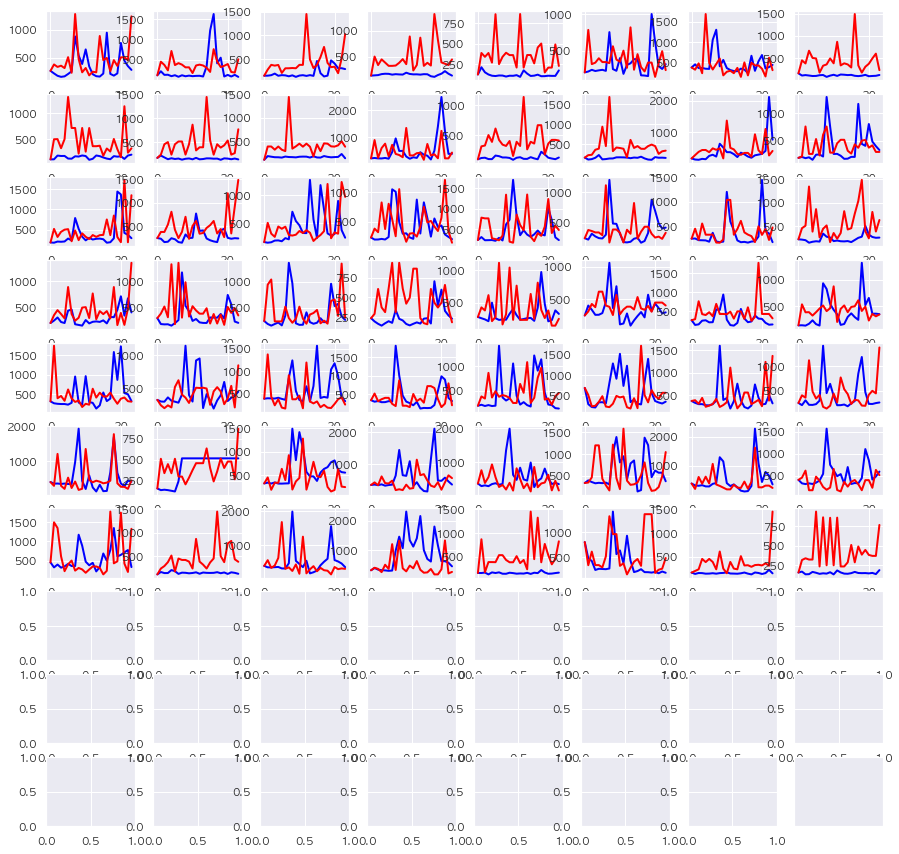

In [112]:
# visual
fig, axes = plt.subplots(10,8, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 1
y = train_y.copy()

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = non_cluster_model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 8)][pi % 8], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 8)][pi % 8], legend=False)

real_pattern: [267. 221. 179. 160. 169. 211. 259. 880. 539. 389. 649. 346. 207. 172.
 165. 219. 947. 213. 182. 222. 765. 447. 351. 284.]
predict_pattern: [267.0, 378.0, 359.0, 458.0, 531.0, 262.0, 242.0, 298.0, 374.0, 919.0, 1046.0, 355.0, 380.0, 410.0, 1448.0, 240.0, 341.0, 336.0, 1344.0, 364.0, 1448.0, 480.0, 299.0, 964.0]
real_pattern: [ 118.  217.  129.  132.   97.  120.   82.  119.   95.  110.   97.  104.
  106.   89.  336. 1218. 1622.  412.  551.   89.  128.   89.  129.   80.]
predict_pattern: [118.0, 452.0, 1490.0, 584.0, 338.0, 308.0, 383.0, 314.0, 416.0, 490.0, 302.0, 140.0, 302.0, 398.0, 385.0, 333.0, 498.0, 767.0, 1495.0, 387.0, 401.0, 249.0, 191.0, 200.0]
real_pattern: [158. 159. 169. 202. 157. 170. 165. 146. 166. 134. 161. 169. 154. 170.
 155. 466. 210. 142. 160. 479. 414. 314. 315. 297.]
predict_pattern: [158.0, 141.0, 385.0, 430.0, 302.0, 223.0, 315.0, 501.0, 385.0, 385.0, 359.0, 404.0, 406.0, 359.0, 510.0, 510.0, 321.0, 207.0, 452.0, 404.0, 426.0, 185.0, 200.0, 252.0]
r

predict_pattern: [211.0, 341.0, 495.0, 282.0, 606.0, 282.0, 266.0, 648.0, 363.0, 511.0, 511.0, 305.0, 478.0, 378.0, 335.0, 378.0, 305.0, 282.0, 326.0, 759.0, 205.0, 302.0, 339.0, 336.0]
real_pattern: [ 289.  175.  169.  171.  145.  193.  251. 1164.  524.  420.  235.  272.
  207.  197.  196.  301.  299.  297.  368.  283.  733.  554.  223.  198.]
predict_pattern: [289.0, 820.0, 511.0, 859.0, 498.0, 584.0, 174.0, 441.0, 322.0, 452.0, 318.0, 216.0, 822.0, 498.0, 299.0, 395.0, 313.0, 1344.0, 282.0, 240.0, 964.0, 976.0, 514.0, 410.0]
real_pattern: [ 242.  185.  153.  184.  213.  158.  345. 1359.  967.  197.  168.  170.
  408.  220.  189.  208.  295.  218.  237.  957.  530.  570.  332.  263.]
predict_pattern: [242.0, 939.0, 1320.0, 1320.0, 262.0, 760.0, 498.0, 409.0, 976.0, 244.0, 310.0, 1039.0, 822.0, 299.0, 299.0, 318.0, 406.0, 239.0, 458.0, 201.0, 209.0, 237.0, 410.0, 249.0]
real_pattern: [237. 196. 166. 143. 173. 199. 178. 340. 229. 209. 164. 146. 166. 184.
 169. 232. 237. 170. 705. 395. 

predict_pattern: [459.0, 498.0, 447.0, 1344.0, 139.0, 375.0, 408.0, 446.0, 594.0, 266.0, 526.0, 182.0, 144.0, 335.0, 1448.0, 376.0, 388.0, 240.0, 240.0, 321.0, 215.0, 349.0, 215.0, 310.0]
real_pattern: [108. 159. 136. 137. 200. 176. 119. 145. 142. 131. 138. 152. 122. 148.
 141. 139. 141. 155. 133. 149. 118. 152. 141. 121.]
predict_pattern: [108.0, 248.0, 381.0, 341.0, 338.0, 498.0, 328.0, 664.0, 767.0, 767.0, 308.0, 248.0, 865.0, 510.0, 510.0, 338.0, 385.0, 377.0, 322.0, 328.0, 510.0, 388.0, 531.0, 1448.0]
real_pattern: [ 396.  354.  352.  358.  365.  321.  321.  472. 1993.  544.  452.  359.
  546.  176.  209.  258.  414.  518.  605. 1564.  566.  526.  466.  360.]
predict_pattern: [396.0, 564.0, 200.0, 335.0, 564.0, 172.0, 207.0, 386.0, 215.0, 446.0, 446.0, 243.0, 215.0, 311.0, 215.0, 388.0, 452.0, 310.0, 275.0, 135.0, 382.0, 382.0, 482.0, 249.0]
real_pattern: [ 320.  397.  342.  323.  316.  302.  310.  985. 1455. 1066. 2303. 1336.
 1120. 1398. 2152. 1001.  702.  615. 1797. 1161.  627.

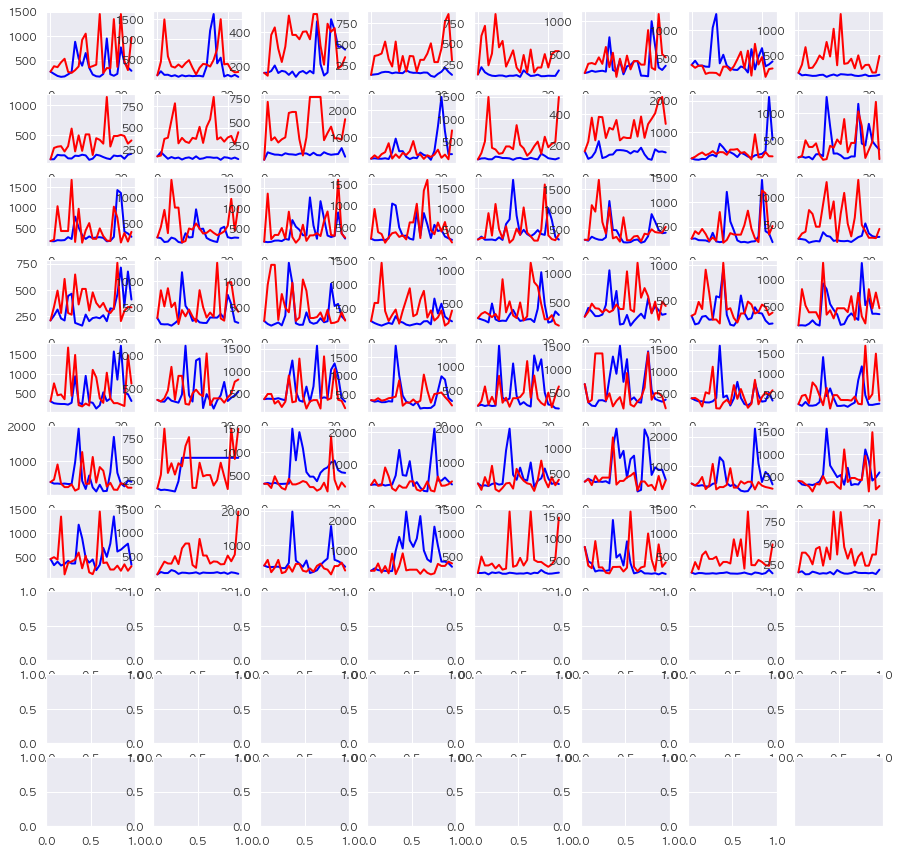

In [114]:
# visual
fig, axes = plt.subplots(10,8, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

cluster_test_real = list()
cluster_test_predict = list()

power_info = 1
y = train_y.copy()

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    cluster_test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = cluster_model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    cluster_test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=cluster_test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 8)][pi % 8], legend=False)
    sns.lineplot(data=cluster_test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 8)][pi % 8], legend=False)

In [124]:
from scipy.spatial import distance
from numpy import dot
from numpy.linalg import norm
import numpy as np
def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

mean_distance_non_cluster = 0
mean_distance_cluster = 0
mean_cos_non_cluster = 0
mean_cos_cluster = 0

for idx in range(0,len(test_real)):
    mean_distance_non_cluster += distance.euclidean(
        test_real[idx],
        test_predict[idx]
    )
    mean_distance_cluster += distance.euclidean(
        cluster_test_real[idx],
        cluster_test_predict[idx]
    )
    
    mean_cos_non_cluster += cos_sim(
        test_real[idx],
        test_predict[idx]
    )
    
    mean_cos_cluster += cos_sim(
        cluster_test_real[idx],
        cluster_test_predict[idx]
    )
    
mean_distance_non_cluster /= len(test_real)
mean_distance_cluster /= len(test_real)
mean_cos_non_cluster /= len(test_real)
mean_cos_cluster /= len(test_real)

print(mean_distance_non_cluster)
print(mean_distance_cluster)
print(mean_cos_non_cluster)
print(mean_cos_cluster)

2078.2903753823202
2069.0299407564953
0.7342148041720106
0.7394423111653249


real_pattern: [267. 221. 179. 160. 169. 211. 259. 880. 539. 389. 649. 346. 207. 172.
 165. 219. 947. 213. 182. 222. 765. 447. 351. 284.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [267.0, 221.0, 179.0, 160.0, 169.0, 511.0, 233.0, 1279.0, 478.0, 241.0, 318.0, 187.0, 252.0, 240.0, 888.0, 458.0, 498.0, 261.0, 458.0, 355.0, 508.0, 508.0, 458.0, 1238.0]
real_pattern: [ 118.  217.  129.  132.   97.  120.   82.  119.   95.  110.   97.  104.
  106.   89.  336. 1218. 1622.  412.  551.   89.  128.   89.  129.   80.]
predict_pattern: [118.0, 217.0, 129.0, 132.0, 97.0, 369.0, 417.0, 380.0, 313.0, 314.0, 174.0, 360.0, 380.0, 359.0, 305.0, 201.0, 760.0, 459.0, 321.0, 352.0, 395.0, 200.0, 185.0, 511.0]
real_pattern: [158. 159. 169. 202. 157. 170. 165. 146. 166. 134. 161. 169. 154. 170.
 155. 466. 210. 142. 160. 479. 414. 314. 315. 297.]
predict_pattern: [158.0, 159.0, 169.0, 202.0, 157.0, 216.0, 313.0, 314.0, 319.0, 314.0, 385.0, 385.0, 1448.0, 498.0, 319.0, 385.0, 550.0, 760.0, 426.0, 338.0, 345.0, 211.0, 517.0, 1028.0]
real_pattern: [134. 139. 144. 163. 170. 168. 153. 162. 157. 154. 190. 166. 158. 159.
 153. 162. 160. 122. 110. 145. 171. 220. 170. 134.]
pred

predict_pattern: [289.0, 175.0, 169.0, 171.0, 145.0, 174.0, 1348.0, 298.0, 976.0, 318.0, 517.0, 435.0, 374.0, 374.0, 478.0, 185.0, 367.0, 185.0, 355.0, 160.0, 503.0, 389.0, 481.0, 340.0]
real_pattern: [ 242.  185.  153.  184.  213.  158.  345. 1359.  967.  197.  168.  170.
  408.  220.  189.  208.  295.  218.  237.  957.  530.  570.  332.  263.]
predict_pattern: [242.0, 185.0, 153.0, 184.0, 213.0, 234.0, 517.0, 298.0, 208.0, 285.0, 517.0, 286.0, 190.0, 366.0, 395.0, 454.0, 198.0, 248.0, 191.0, 628.0, 655.0, 340.0, 1344.0, 305.0]
real_pattern: [237. 196. 166. 143. 173. 199. 178. 340. 229. 209. 164. 146. 166. 184.
 169. 232. 237. 170. 705. 395. 599. 330. 272. 232.]
predict_pattern: [237.0, 196.0, 166.0, 143.0, 173.0, 614.0, 939.0, 313.0, 939.0, 614.0, 421.0, 498.0, 865.0, 865.0, 239.0, 174.0, 160.0, 608.0, 434.0, 372.0, 434.0, 659.0, 364.0, 185.0]
real_pattern: [277. 258. 240. 212. 498. 258. 232. 239. 235. 326. 401. 304. 235. 246.
 259. 263. 218. 419. 970. 478. 210. 228. 379. 325.]
predi

predict_pattern: [108.0, 159.0, 136.0, 137.0, 200.0, 171.0, 446.0, 416.0, 416.0, 381.0, 233.0, 865.0, 381.0, 316.0, 233.0, 363.0, 447.0, 1448.0, 498.0, 369.0, 767.0, 822.0, 430.0, 377.0]
real_pattern: [ 396.  354.  352.  358.  365.  321.  321.  472. 1993.  544.  452.  359.
  546.  176.  209.  258.  414.  518.  605. 1564.  566.  526.  466.  360.]
predict_pattern: [396.0, 354.0, 352.0, 358.0, 365.0, 1684.0, 310.0, 353.0, 247.0, 439.0, 164.0, 1255.0, 177.0, 295.0, 388.0, 239.0, 337.0, 269.0, 254.0, 146.0, 363.0, 300.0, 321.0, 309.0]
real_pattern: [ 320.  397.  342.  323.  316.  302.  310.  985. 1455. 1066. 2303. 1336.
 1120. 1398. 2152. 1001.  702.  615. 1797. 1161.  627.  627.  574.  453.]
predict_pattern: [320.0, 397.0, 342.0, 323.0, 316.0, 367.0, 1202.0, 331.0, 1320.0, 386.0, 283.0, 478.0, 387.0, 632.0, 337.0, 237.0, 249.0, 363.0, 181.0, 181.0, 353.0, 1328.0, 213.0, 265.0]
real_pattern: [156. 155. 164. 126. 168. 155. 169. 140. 139. 161. 153. 141. 146. 143.
 159. 136. 161. 153. 218. 166

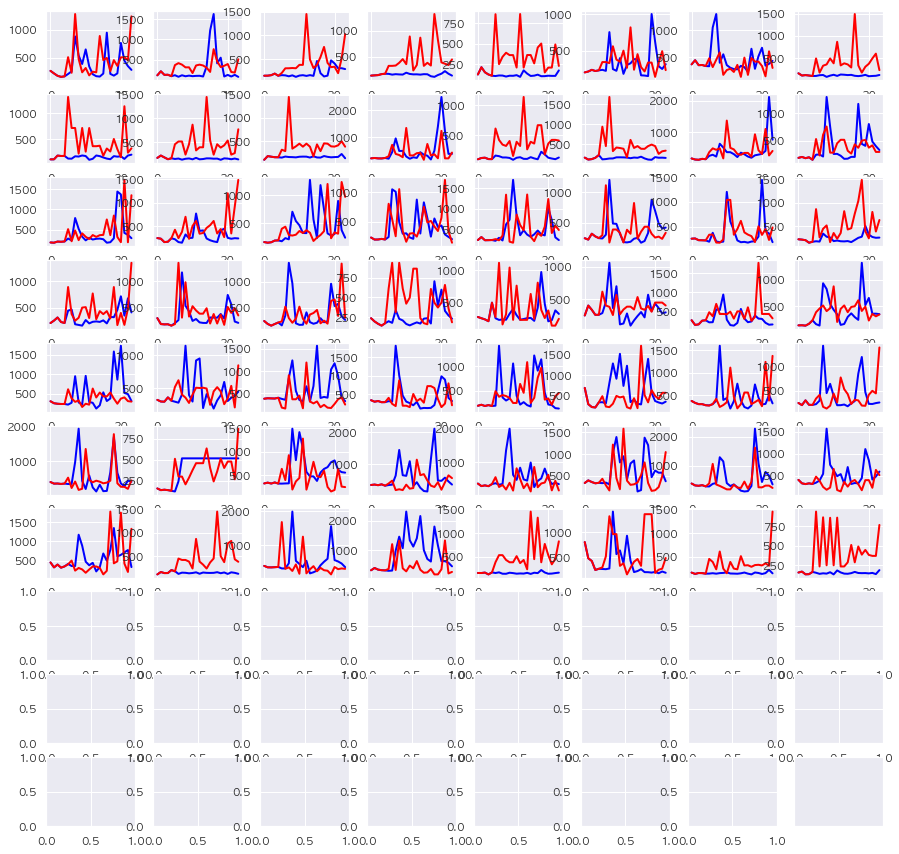

In [125]:
# visual
fig, axes = plt.subplots(10,8, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 5
y = train_y.copy()

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = non_cluster_model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 8)][pi % 8], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 8)][pi % 8], legend=False)

real_pattern: [267. 221. 179. 160. 169. 211. 259. 880. 539. 389. 649. 346. 207. 172.
 165. 219. 947. 213. 182. 222. 765. 447. 351. 284.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [267.0, 221.0, 179.0, 160.0, 169.0, 262.0, 242.0, 298.0, 374.0, 919.0, 1046.0, 355.0, 380.0, 410.0, 1448.0, 240.0, 341.0, 336.0, 1344.0, 364.0, 1448.0, 480.0, 299.0, 964.0]
real_pattern: [ 118.  217.  129.  132.   97.  120.   82.  119.   95.  110.   97.  104.
  106.   89.  336. 1218. 1622.  412.  551.   89.  128.   89.  129.   80.]
predict_pattern: [118.0, 217.0, 129.0, 132.0, 97.0, 308.0, 383.0, 314.0, 416.0, 490.0, 302.0, 140.0, 302.0, 398.0, 385.0, 333.0, 498.0, 767.0, 1495.0, 387.0, 401.0, 249.0, 191.0, 200.0]
real_pattern: [158. 159. 169. 202. 157. 170. 165. 146. 166. 134. 161. 169. 154. 170.
 155. 466. 210. 142. 160. 479. 414. 314. 315. 297.]
predict_pattern: [158.0, 159.0, 169.0, 202.0, 157.0, 223.0, 315.0, 501.0, 385.0, 385.0, 359.0, 404.0, 406.0, 359.0, 510.0, 510.0, 321.0, 207.0, 452.0, 404.0, 426.0, 185.0, 200.0, 252.0]
real_pattern: [134. 139. 144. 163. 170. 168. 153. 162. 157. 154. 190. 166. 158. 159.
 153. 162. 160. 122. 110. 145. 171. 220. 170. 134.]
pre

predict_pattern: [289.0, 175.0, 169.0, 171.0, 145.0, 584.0, 174.0, 441.0, 322.0, 452.0, 318.0, 216.0, 822.0, 498.0, 299.0, 395.0, 313.0, 1344.0, 282.0, 240.0, 964.0, 976.0, 514.0, 410.0]
real_pattern: [ 242.  185.  153.  184.  213.  158.  345. 1359.  967.  197.  168.  170.
  408.  220.  189.  208.  295.  218.  237.  957.  530.  570.  332.  263.]
predict_pattern: [242.0, 185.0, 153.0, 184.0, 213.0, 760.0, 498.0, 409.0, 976.0, 244.0, 310.0, 1039.0, 822.0, 299.0, 299.0, 318.0, 406.0, 239.0, 458.0, 201.0, 209.0, 237.0, 410.0, 249.0]
real_pattern: [237. 196. 166. 143. 173. 199. 178. 340. 229. 209. 164. 146. 166. 184.
 169. 232. 237. 170. 705. 395. 599. 330. 272. 232.]
predict_pattern: [237.0, 196.0, 166.0, 143.0, 173.0, 239.0, 366.0, 478.0, 184.0, 452.0, 684.0, 919.0, 338.0, 381.0, 684.0, 865.0, 310.0, 458.0, 249.0, 315.0, 458.0, 144.0, 198.0, 454.0]
real_pattern: [277. 258. 240. 212. 498. 258. 232. 239. 235. 326. 401. 304. 235. 246.
 259. 263. 218. 419. 970. 478. 210. 228. 379. 325.]
predi

predict_pattern: [108.0, 159.0, 136.0, 137.0, 200.0, 498.0, 328.0, 664.0, 767.0, 767.0, 308.0, 248.0, 865.0, 510.0, 510.0, 338.0, 385.0, 377.0, 322.0, 328.0, 510.0, 388.0, 531.0, 1448.0]
real_pattern: [ 396.  354.  352.  358.  365.  321.  321.  472. 1993.  544.  452.  359.
  546.  176.  209.  258.  414.  518.  605. 1564.  566.  526.  466.  360.]
predict_pattern: [396.0, 354.0, 352.0, 358.0, 365.0, 172.0, 207.0, 386.0, 215.0, 446.0, 446.0, 243.0, 215.0, 311.0, 215.0, 388.0, 452.0, 310.0, 275.0, 135.0, 382.0, 382.0, 482.0, 249.0]
real_pattern: [ 320.  397.  342.  323.  316.  302.  310.  985. 1455. 1066. 2303. 1336.
 1120. 1398. 2152. 1001.  702.  615. 1797. 1161.  627.  627.  574.  453.]
predict_pattern: [320.0, 397.0, 342.0, 323.0, 316.0, 232.0, 895.0, 207.0, 467.0, 903.0, 332.0, 355.0, 355.0, 355.0, 215.0, 366.0, 249.0, 197.0, 233.0, 550.0, 480.0, 480.0, 625.0, 564.0]
real_pattern: [156. 155. 164. 126. 168. 155. 169. 140. 139. 161. 153. 141. 146. 143.
 159. 136. 161. 153. 218. 166. 140

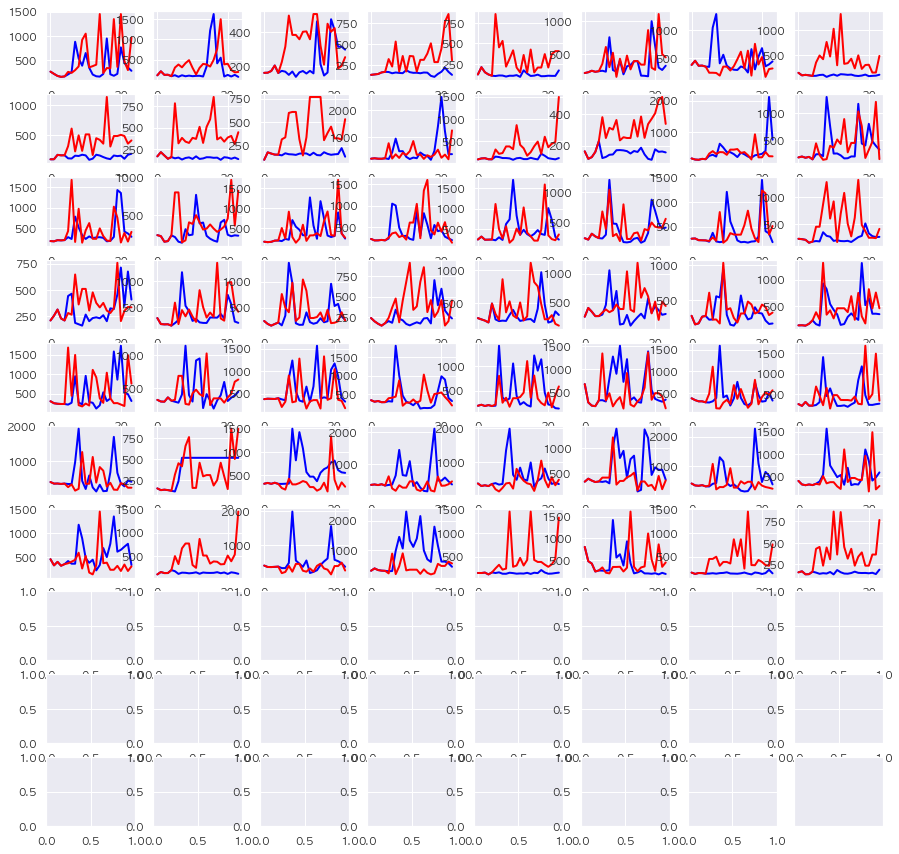

In [126]:
# visual
fig, axes = plt.subplots(10,8, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

cluster_test_real = list()
cluster_test_predict = list()

power_info = 5
y = train_y.copy()

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    cluster_test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = cluster_model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    cluster_test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=cluster_test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 8)][pi % 8], legend=False)
    sns.lineplot(data=cluster_test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 8)][pi % 8], legend=False)

In [127]:
from scipy.spatial import distance
from numpy import dot
from numpy.linalg import norm
import numpy as np
def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

mean_distance_non_cluster = 0
mean_distance_cluster = 0
mean_cos_non_cluster = 0
mean_cos_cluster = 0

for idx in range(0,len(test_real)):
    mean_distance_non_cluster += distance.euclidean(
        test_real[idx],
        test_predict[idx]
    )
    mean_distance_cluster += distance.euclidean(
        cluster_test_real[idx],
        cluster_test_predict[idx]
    )
    
    mean_cos_non_cluster += cos_sim(
        test_real[idx],
        test_predict[idx]
    )
    
    mean_cos_cluster += cos_sim(
        cluster_test_real[idx],
        cluster_test_predict[idx]
    )
    
mean_distance_non_cluster /= len(test_real)
mean_distance_cluster /= len(test_real)
mean_cos_non_cluster /= len(test_real)
mean_cos_cluster /= len(test_real)

print(mean_distance_non_cluster)
print(mean_distance_cluster)
print(mean_cos_non_cluster)
print(mean_cos_cluster)

1956.7584750396386
1913.3840432304294
0.7425187660236789
0.7498082844302967


real_pattern: [267. 221. 179. 160. 169. 211. 259. 880. 539. 389. 649. 346. 207. 172.
 165. 219. 947. 213. 182. 222. 765. 447. 351. 284.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [267.0, 221.0, 179.0, 160.0, 169.0, 211.0, 259.0, 880.0, 539.0, 389.0, 318.0, 187.0, 252.0, 240.0, 888.0, 458.0, 498.0, 261.0, 458.0, 355.0, 508.0, 508.0, 458.0, 1238.0]
real_pattern: [ 118.  217.  129.  132.   97.  120.   82.  119.   95.  110.   97.  104.
  106.   89.  336. 1218. 1622.  412.  551.   89.  128.   89.  129.   80.]
predict_pattern: [118.0, 217.0, 129.0, 132.0, 97.0, 120.0, 82.0, 119.0, 95.0, 110.0, 174.0, 360.0, 380.0, 359.0, 305.0, 201.0, 760.0, 459.0, 321.0, 352.0, 395.0, 200.0, 185.0, 511.0]
real_pattern: [158. 159. 169. 202. 157. 170. 165. 146. 166. 134. 161. 169. 154. 170.
 155. 466. 210. 142. 160. 479. 414. 314. 315. 297.]
predict_pattern: [158.0, 159.0, 169.0, 202.0, 157.0, 170.0, 165.0, 146.0, 166.0, 134.0, 385.0, 385.0, 1448.0, 498.0, 319.0, 385.0, 550.0, 760.0, 426.0, 338.0, 345.0, 211.0, 517.0, 1028.0]
real_pattern: [134. 139. 144. 163. 170. 168. 153. 162. 157. 154. 190. 166. 158. 159.
 153. 162. 160. 122. 110. 145. 171. 220. 170. 134.]
predict

predict_pattern: [289.0, 175.0, 169.0, 171.0, 145.0, 193.0, 251.0, 1164.0, 524.0, 420.0, 517.0, 435.0, 374.0, 374.0, 478.0, 185.0, 367.0, 185.0, 355.0, 160.0, 503.0, 389.0, 481.0, 340.0]
real_pattern: [ 242.  185.  153.  184.  213.  158.  345. 1359.  967.  197.  168.  170.
  408.  220.  189.  208.  295.  218.  237.  957.  530.  570.  332.  263.]
predict_pattern: [242.0, 185.0, 153.0, 184.0, 213.0, 158.0, 345.0, 1359.0, 967.0, 197.0, 517.0, 286.0, 190.0, 366.0, 395.0, 454.0, 198.0, 248.0, 191.0, 628.0, 655.0, 340.0, 1344.0, 305.0]
real_pattern: [237. 196. 166. 143. 173. 199. 178. 340. 229. 209. 164. 146. 166. 184.
 169. 232. 237. 170. 705. 395. 599. 330. 272. 232.]
predict_pattern: [237.0, 196.0, 166.0, 143.0, 173.0, 199.0, 178.0, 340.0, 229.0, 209.0, 421.0, 498.0, 865.0, 865.0, 239.0, 174.0, 160.0, 608.0, 434.0, 372.0, 434.0, 659.0, 364.0, 185.0]
real_pattern: [277. 258. 240. 212. 498. 258. 232. 239. 235. 326. 401. 304. 235. 246.
 259. 263. 218. 419. 970. 478. 210. 228. 379. 325.]
pred

predict_pattern: [108.0, 159.0, 136.0, 137.0, 200.0, 176.0, 119.0, 145.0, 142.0, 131.0, 233.0, 865.0, 381.0, 316.0, 233.0, 363.0, 447.0, 1448.0, 498.0, 369.0, 767.0, 822.0, 430.0, 377.0]
real_pattern: [ 396.  354.  352.  358.  365.  321.  321.  472. 1993.  544.  452.  359.
  546.  176.  209.  258.  414.  518.  605. 1564.  566.  526.  466.  360.]
predict_pattern: [396.0, 354.0, 352.0, 358.0, 365.0, 321.0, 321.0, 472.0, 1993.0, 544.0, 164.0, 1255.0, 177.0, 295.0, 388.0, 239.0, 337.0, 269.0, 254.0, 146.0, 363.0, 300.0, 321.0, 309.0]
real_pattern: [ 320.  397.  342.  323.  316.  302.  310.  985. 1455. 1066. 2303. 1336.
 1120. 1398. 2152. 1001.  702.  615. 1797. 1161.  627.  627.  574.  453.]
predict_pattern: [320.0, 397.0, 342.0, 323.0, 316.0, 302.0, 310.0, 985.0, 1455.0, 1066.0, 283.0, 478.0, 387.0, 632.0, 337.0, 237.0, 249.0, 363.0, 181.0, 181.0, 353.0, 1328.0, 213.0, 265.0]
real_pattern: [156. 155. 164. 126. 168. 155. 169. 140. 139. 161. 153. 141. 146. 143.
 159. 136. 161. 153. 218. 166

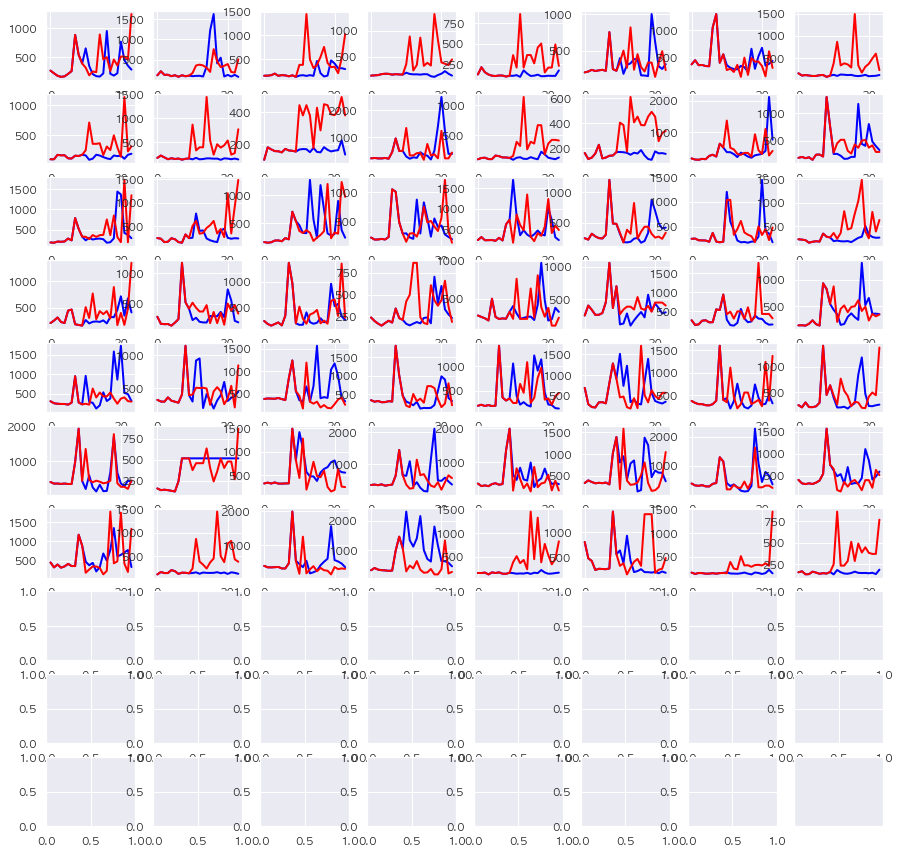

In [128]:
# visual
fig, axes = plt.subplots(10,8, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 10
y = train_y.copy()

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = non_cluster_model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 8)][pi % 8], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 8)][pi % 8], legend=False)

real_pattern: [267. 221. 179. 160. 169. 211. 259. 880. 539. 389. 649. 346. 207. 172.
 165. 219. 947. 213. 182. 222. 765. 447. 351. 284.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [267.0, 221.0, 179.0, 160.0, 169.0, 211.0, 259.0, 880.0, 539.0, 389.0, 1046.0, 355.0, 380.0, 410.0, 1448.0, 240.0, 341.0, 336.0, 1344.0, 364.0, 1448.0, 480.0, 299.0, 964.0]
real_pattern: [ 118.  217.  129.  132.   97.  120.   82.  119.   95.  110.   97.  104.
  106.   89.  336. 1218. 1622.  412.  551.   89.  128.   89.  129.   80.]
predict_pattern: [118.0, 217.0, 129.0, 132.0, 97.0, 120.0, 82.0, 119.0, 95.0, 110.0, 302.0, 140.0, 302.0, 398.0, 385.0, 333.0, 498.0, 767.0, 1495.0, 387.0, 401.0, 249.0, 191.0, 200.0]
real_pattern: [158. 159. 169. 202. 157. 170. 165. 146. 166. 134. 161. 169. 154. 170.
 155. 466. 210. 142. 160. 479. 414. 314. 315. 297.]
predict_pattern: [158.0, 159.0, 169.0, 202.0, 157.0, 170.0, 165.0, 146.0, 166.0, 134.0, 359.0, 404.0, 406.0, 359.0, 510.0, 510.0, 321.0, 207.0, 452.0, 404.0, 426.0, 185.0, 200.0, 252.0]
real_pattern: [134. 139. 144. 163. 170. 168. 153. 162. 157. 154. 190. 166. 158. 159.
 153. 162. 160. 122. 110. 145. 171. 220. 170. 134.]
predi

predict_pattern: [289.0, 175.0, 169.0, 171.0, 145.0, 193.0, 251.0, 1164.0, 524.0, 420.0, 318.0, 216.0, 822.0, 498.0, 299.0, 395.0, 313.0, 1344.0, 282.0, 240.0, 964.0, 976.0, 514.0, 410.0]
real_pattern: [ 242.  185.  153.  184.  213.  158.  345. 1359.  967.  197.  168.  170.
  408.  220.  189.  208.  295.  218.  237.  957.  530.  570.  332.  263.]
predict_pattern: [242.0, 185.0, 153.0, 184.0, 213.0, 158.0, 345.0, 1359.0, 967.0, 197.0, 310.0, 1039.0, 822.0, 299.0, 299.0, 318.0, 406.0, 239.0, 458.0, 201.0, 209.0, 237.0, 410.0, 249.0]
real_pattern: [237. 196. 166. 143. 173. 199. 178. 340. 229. 209. 164. 146. 166. 184.
 169. 232. 237. 170. 705. 395. 599. 330. 272. 232.]
predict_pattern: [237.0, 196.0, 166.0, 143.0, 173.0, 199.0, 178.0, 340.0, 229.0, 209.0, 684.0, 919.0, 338.0, 381.0, 684.0, 865.0, 310.0, 458.0, 249.0, 315.0, 458.0, 144.0, 198.0, 454.0]
real_pattern: [277. 258. 240. 212. 498. 258. 232. 239. 235. 326. 401. 304. 235. 246.
 259. 263. 218. 419. 970. 478. 210. 228. 379. 325.]
pre

predict_pattern: [108.0, 159.0, 136.0, 137.0, 200.0, 176.0, 119.0, 145.0, 142.0, 131.0, 308.0, 248.0, 865.0, 510.0, 510.0, 338.0, 385.0, 377.0, 322.0, 328.0, 510.0, 388.0, 531.0, 1448.0]
real_pattern: [ 396.  354.  352.  358.  365.  321.  321.  472. 1993.  544.  452.  359.
  546.  176.  209.  258.  414.  518.  605. 1564.  566.  526.  466.  360.]
predict_pattern: [396.0, 354.0, 352.0, 358.0, 365.0, 321.0, 321.0, 472.0, 1993.0, 544.0, 446.0, 243.0, 215.0, 311.0, 215.0, 388.0, 452.0, 310.0, 275.0, 135.0, 382.0, 382.0, 482.0, 249.0]
real_pattern: [ 320.  397.  342.  323.  316.  302.  310.  985. 1455. 1066. 2303. 1336.
 1120. 1398. 2152. 1001.  702.  615. 1797. 1161.  627.  627.  574.  453.]
predict_pattern: [320.0, 397.0, 342.0, 323.0, 316.0, 302.0, 310.0, 985.0, 1455.0, 1066.0, 332.0, 355.0, 355.0, 355.0, 215.0, 366.0, 249.0, 197.0, 233.0, 550.0, 480.0, 480.0, 625.0, 564.0]
real_pattern: [156. 155. 164. 126. 168. 155. 169. 140. 139. 161. 153. 141. 146. 143.
 159. 136. 161. 153. 218. 166. 

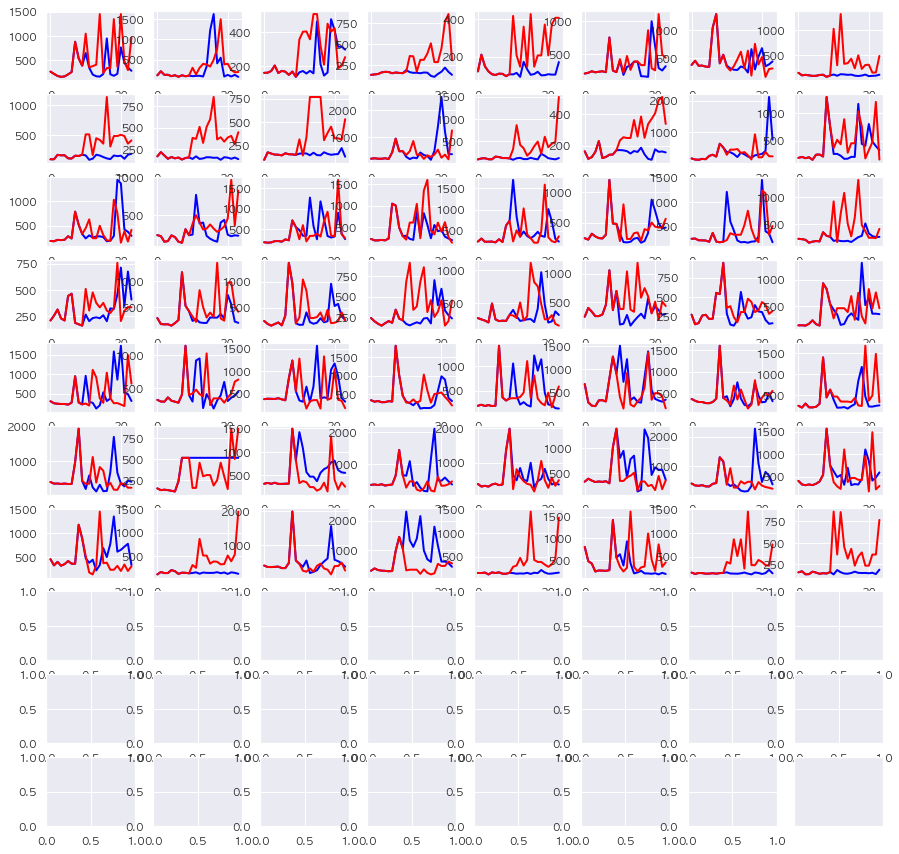

In [129]:
# visual
fig, axes = plt.subplots(10,8, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

cluster_test_real = list()
cluster_test_predict = list()

power_info = 10
y = train_y.copy()

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    cluster_test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = cluster_model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    cluster_test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=cluster_test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 8)][pi % 8], legend=False)
    sns.lineplot(data=cluster_test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 8)][pi % 8], legend=False)

In [130]:
from scipy.spatial import distance
from numpy import dot
from numpy.linalg import norm
import numpy as np
def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

mean_distance_non_cluster = 0
mean_distance_cluster = 0
mean_cos_non_cluster = 0
mean_cos_cluster = 0

for idx in range(0,len(test_real)):
    mean_distance_non_cluster += distance.euclidean(
        test_real[idx],
        test_predict[idx]
    )
    mean_distance_cluster += distance.euclidean(
        cluster_test_real[idx],
        cluster_test_predict[idx]
    )
    
    mean_cos_non_cluster += cos_sim(
        test_real[idx],
        test_predict[idx]
    )
    
    mean_cos_cluster += cos_sim(
        cluster_test_real[idx],
        cluster_test_predict[idx]
    )
    
mean_distance_non_cluster /= len(test_real)
mean_distance_cluster /= len(test_real)
mean_cos_non_cluster /= len(test_real)
mean_cos_cluster /= len(test_real)

print(mean_distance_non_cluster)
print(mean_distance_cluster)
print(mean_cos_non_cluster)
print(mean_cos_cluster)

1593.1839973544559
1587.327125625854
0.8096874618090081
0.8107457063619333


In [156]:
mean_result = pd.DataFrame(columns=[
                                'power-info',
                                'non-cluster-distance',
                                'non-cluster-cosine-similarity',
                                'cluster-distance',
                                'cluster-cosine-similarity',
                                ])

mean_result

,power-info,non-cluster-distance,non-cluster-cosine-similarity,cluster-distance,cluster-cosine-similarity


In [161]:
TEST_POWER_INFO = [1,3,5,10,15,20]

for power_info in TEST_POWER_INFO:
    test_real = list()
    test_predict = list()
    cluster_test_predict = list()

    y = train_y.copy()
    
    print("####################################")
    print("#  하루 전력 사용 패턴 {}시간이 주어졌을 때  #".format(power_info))
    print("####################################")
    
    for i in range(0, round(len(test_X) / 24)):
        if i % 5 == 0:
            print("#########")
            print("# {}/{}  #".format(i,round(len(test_X) / 24)))
            print("#########")
        start_idx = 24 * i
        end_idx = (24 * (i + 1))

        real_pattern = test_X[end_idx-1][-23:]
        real_pattern = np.append(real_pattern, [test_y[end_idx-1]])

        test_real.append(real_pattern)

        predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()
        cluster_predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

        for p in range(start_idx + power_info, end_idx):
            result = non_cluster_model.predict_classes([test_X[p].tolist()])
            cluster_result = cluster_model.predict_classes([test_X[p].tolist()])
            predict_pattern.append(y[result[0]])
            cluster_predict_pattern.append(y[cluster_result[0]])
        test_predict.append(predict_pattern)
        cluster_test_predict.append(cluster_predict_pattern)

    mean_distance_non_cluster = 0
    mean_distance_cluster = 0
    mean_cos_non_cluster = 0
    mean_cos_cluster = 0

    for idx in range(0,len(test_real)):
        mean_distance_non_cluster += distance.euclidean(
            test_real[idx],
            test_predict[idx]
        )
        mean_distance_cluster += distance.euclidean(
            test_real[idx],
            cluster_test_predict[idx]
        )

        mean_cos_non_cluster += cos_sim(
            test_real[idx],
            test_predict[idx]
        )

        mean_cos_cluster += cos_sim(
            test_real[idx],
            cluster_test_predict[idx]
        )

    mean_distance_non_cluster /= len(test_real)
    mean_distance_cluster /= len(test_real)
    mean_cos_non_cluster /= len(test_real)
    mean_cos_cluster /= len(test_real)
    
    new_mean_data = {
        'power-info': power_info,
        'non-cluster-distance': mean_distance_non_cluster,
        'non-cluster-cosine-similarity': mean_cos_non_cluster,
        'cluster-distance': mean_distance_cluster,
        'cluster-cosine-similarity': mean_cos_cluster
    }
    print(new_mean_data)
    mean_result = mean_result.append(new_mean_data, ignore_index=True)
    

####################################
#  하루 전력 사용 패턴 1시간이 주어졌을 때  #
####################################
#########
# 0/56  #
#########
#########
# 5/56  #
#########
#########
# 10/56  #
#########
#########
# 15/56  #
#########
#########
# 20/56  #
#########
#########
# 25/56  #
#########
#########
# 30/56  #
#########
#########
# 35/56  #
#########
#########
# 40/56  #
#########
#########
# 45/56  #
#########
#########
# 50/56  #
#########
#########
# 55/56  #
#########
{'power-info': 1, 'non-cluster-distance': 2078.2903753823202, 'non-cluster-cosine-similarity': 0.7342148041720106, 'cluster-distance': 2069.0299407564953, 'cluster-cosine-similarity': 0.7394423111653249}
####################################
#  하루 전력 사용 패턴 3시간이 주어졌을 때  #
####################################
#########
# 0/56  #
#########
#########
# 5/56  #
#########
#########
# 10/56  #
#########
#########
# 15/56  #
#########
#########
# 20/56  #
#########
#########
# 25/56  #
#########
#########
# 30/56  #
#########
###

In [162]:
mean_result

,power-info,non-cluster-distance,non-cluster-cosine-similarity,cluster-distance,cluster-cosine-similarity
0,1.0,2078.290375,0.734215,2069.029941,0.739442
1,1.0,2078.290375,0.734215,2069.029941,0.739442
2,3.0,2021.218046,0.738312,2008.135275,0.740668
3,5.0,1956.758475,0.742519,1913.384043,0.749808
4,10.0,1593.183997,0.809687,1587.327126,0.810746
5,15.0,1304.947456,0.846509,1285.801759,0.844693
6,20.0,783.562629,0.911263,704.354672,0.921093
